In [1]:
import os
from zlib import crc32
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

## Functions

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def test_set_check(indentifier, test_ratio):
    return crc32(np.int64(indentifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    rooms_ix = 3
    bedrooms_ix = 4
    population_ix = 5
    household_ix = 6
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        attrs = []
        rooms_per_household = X[:, self.rooms_ix] / X[:, self.household_ix]
        attrs.append(rooms_per_household)
        
        population_per_household = X[:, self.population_ix] / X[:, self.household_ix]
        attrs.append(population_per_household)
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
            attrs.append(bedrooms_per_room)
        
        
        return np.c_[X, np.stack(attrs, axis=1)]
        
            

In [4]:
fetch_housing_data()

In [5]:
housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


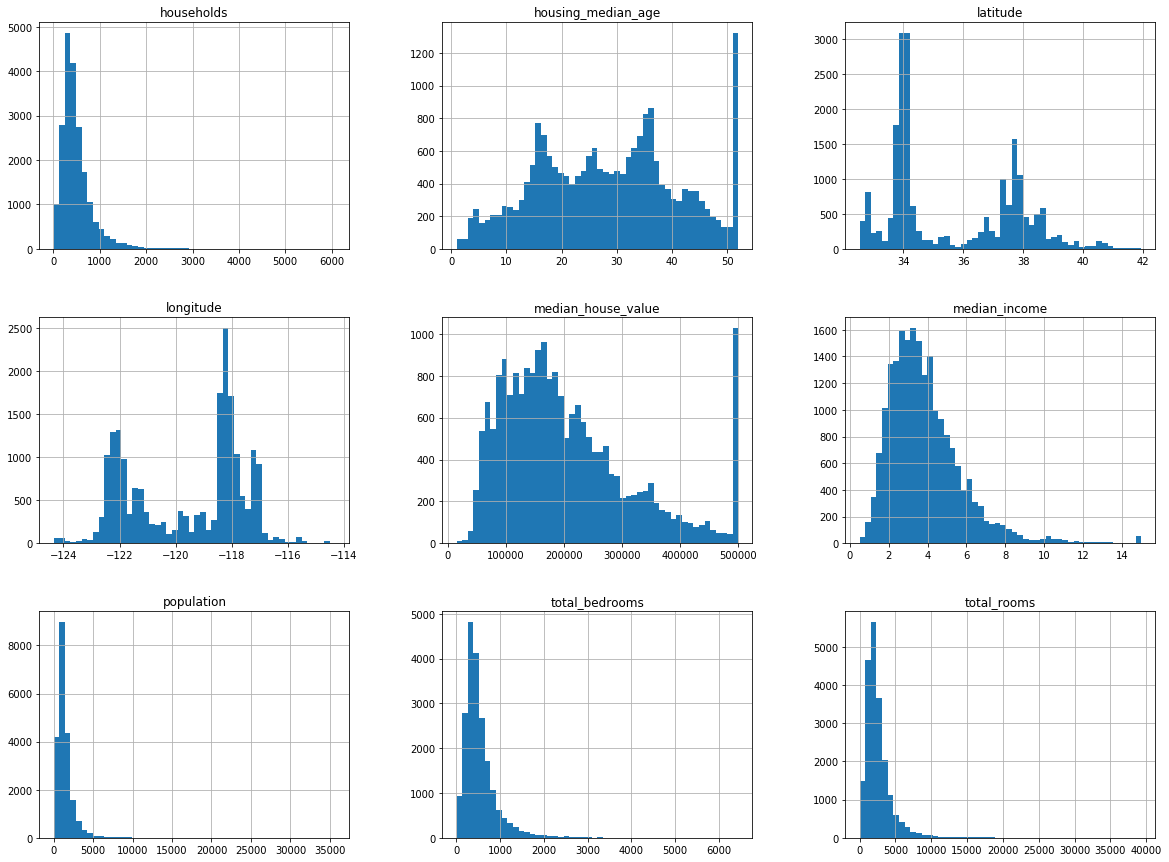

In [10]:
housing.hist(bins=50, figsize=(20, 15));

In [11]:
train_df, test_df = split_train_test(housing, 0.2)

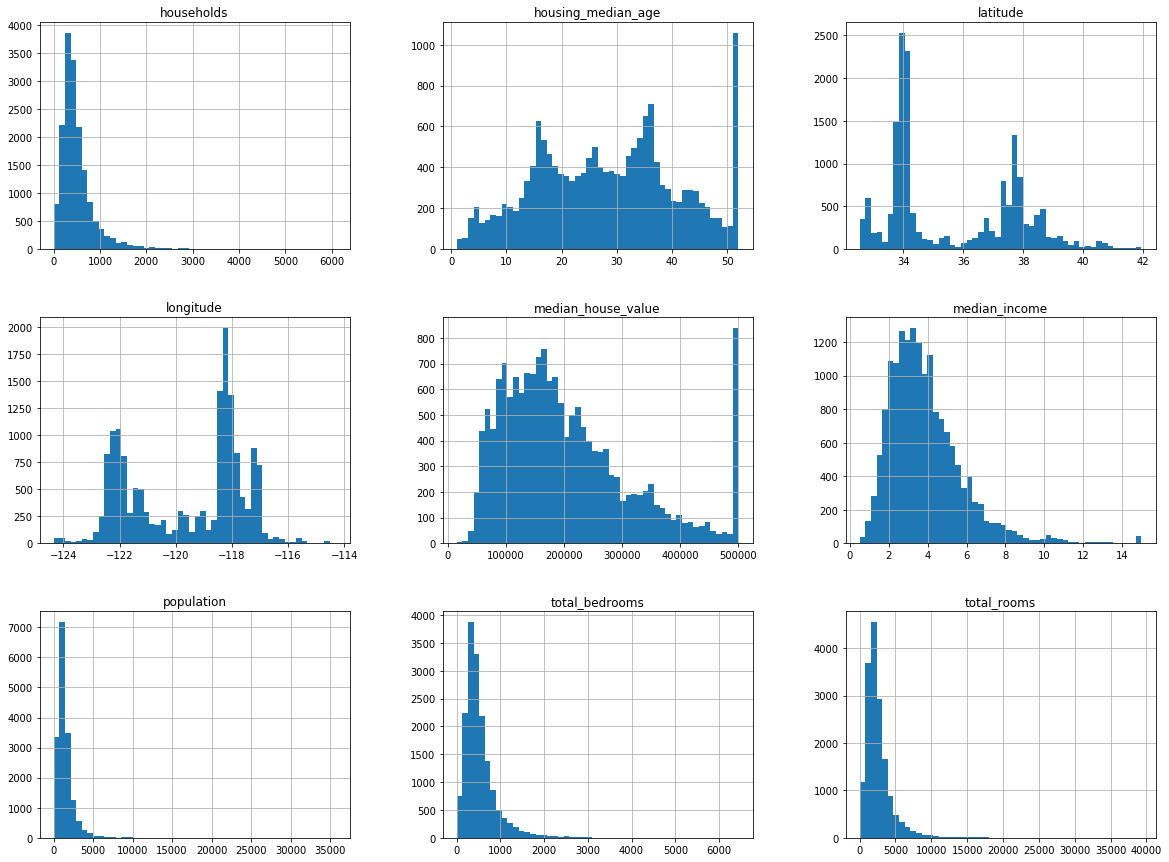

In [12]:
train_df.hist(bins=50, figsize=(20, 15));

In [13]:
housing_with_id = housing.reset_index()

In [14]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

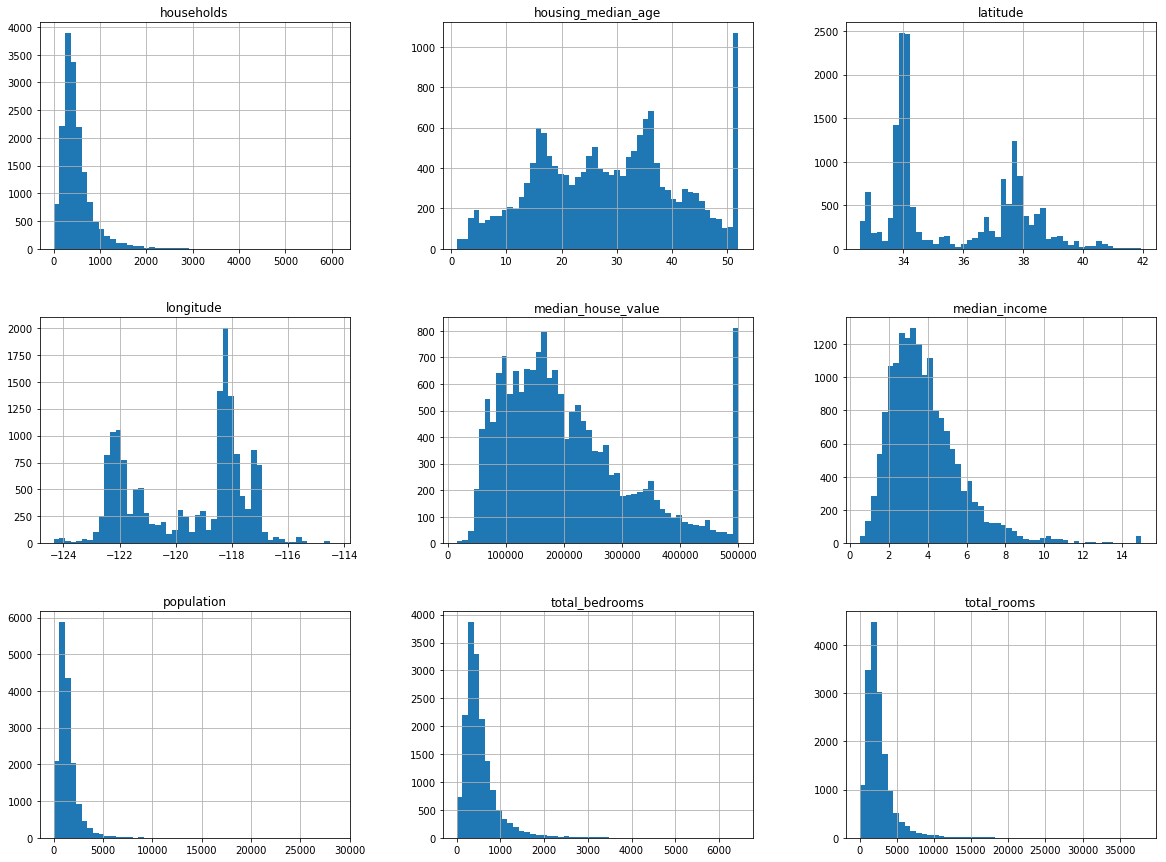

In [15]:
train_set.drop('index', axis=1).hist(bins=50, figsize=(20, 15));

In [16]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

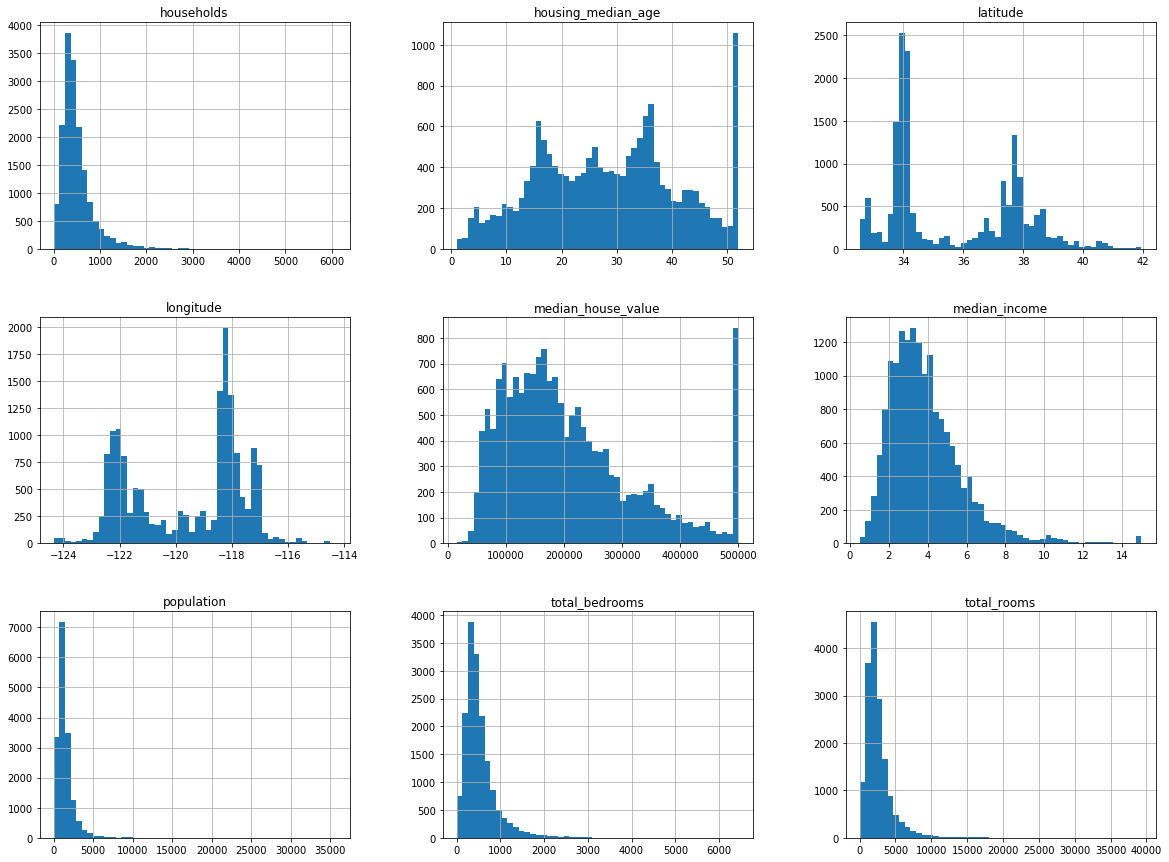

In [17]:
train_set.hist(bins=50, figsize=(20, 15));

In [18]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

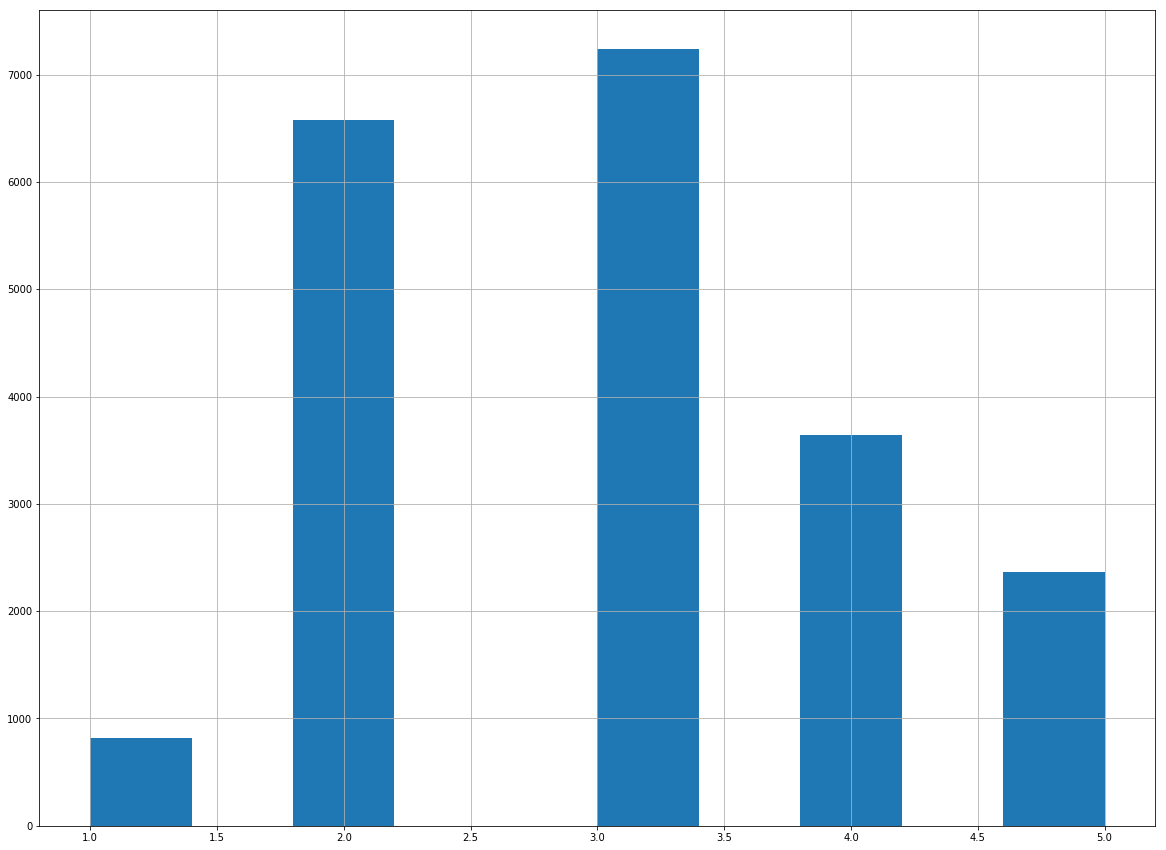

In [19]:
housing['income_cat'].hist(figsize=(20, 15));

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [22]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [24]:
housing_cp = strat_train_set.copy()

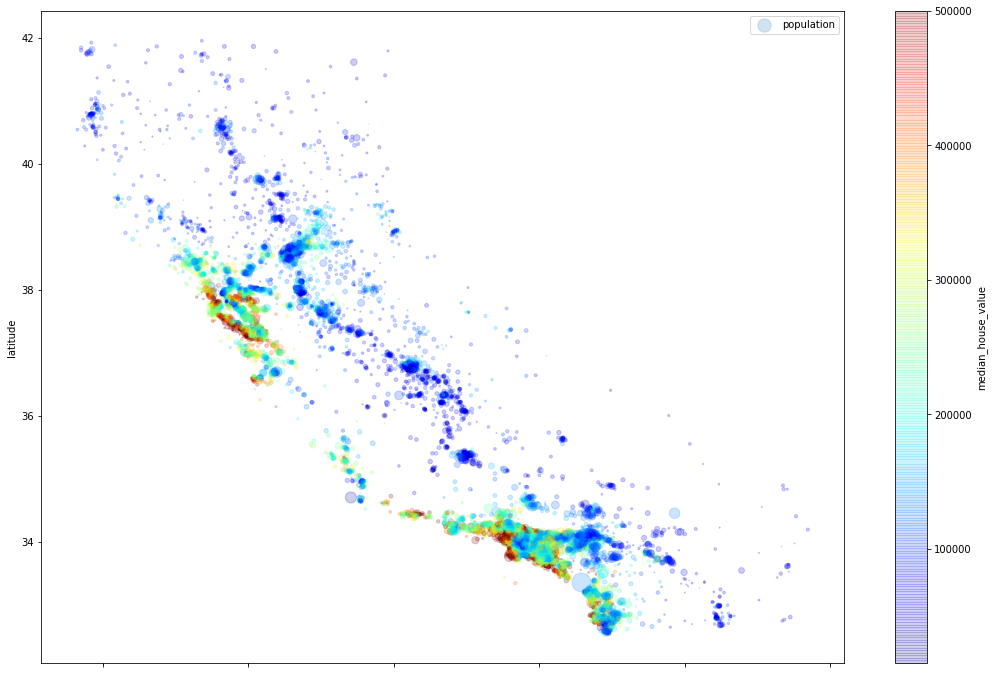

In [25]:
housing_cp.plot(kind='scatter', x='longitude', y='latitude', cmap=plt.get_cmap('jet'),
                alpha=0.2, s=housing_cp['population'] / 100, c='median_house_value', 
                label='population', figsize=(18, 12));

In [26]:
corr_matrix = housing_cp.corr()

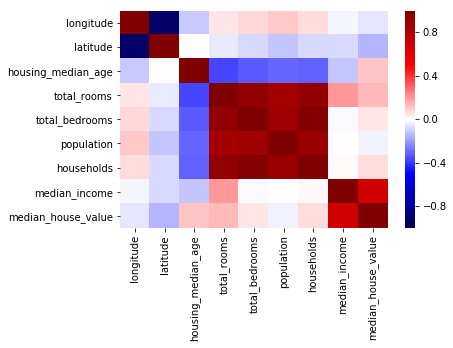

In [27]:
sns.heatmap(corr_matrix, cmap='seismic', vmin=-1, vmax=1);

In [28]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

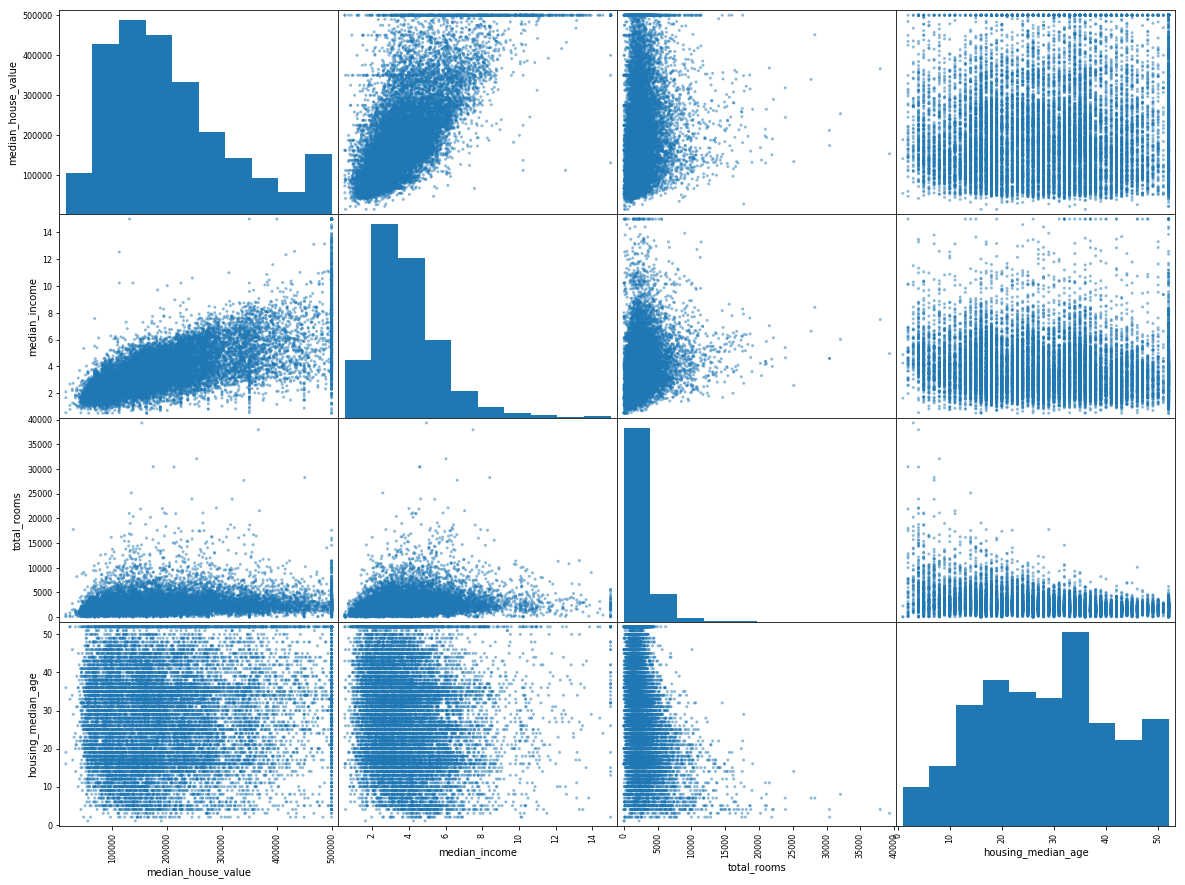

In [29]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing_cp[attributes], figsize=(20, 15));

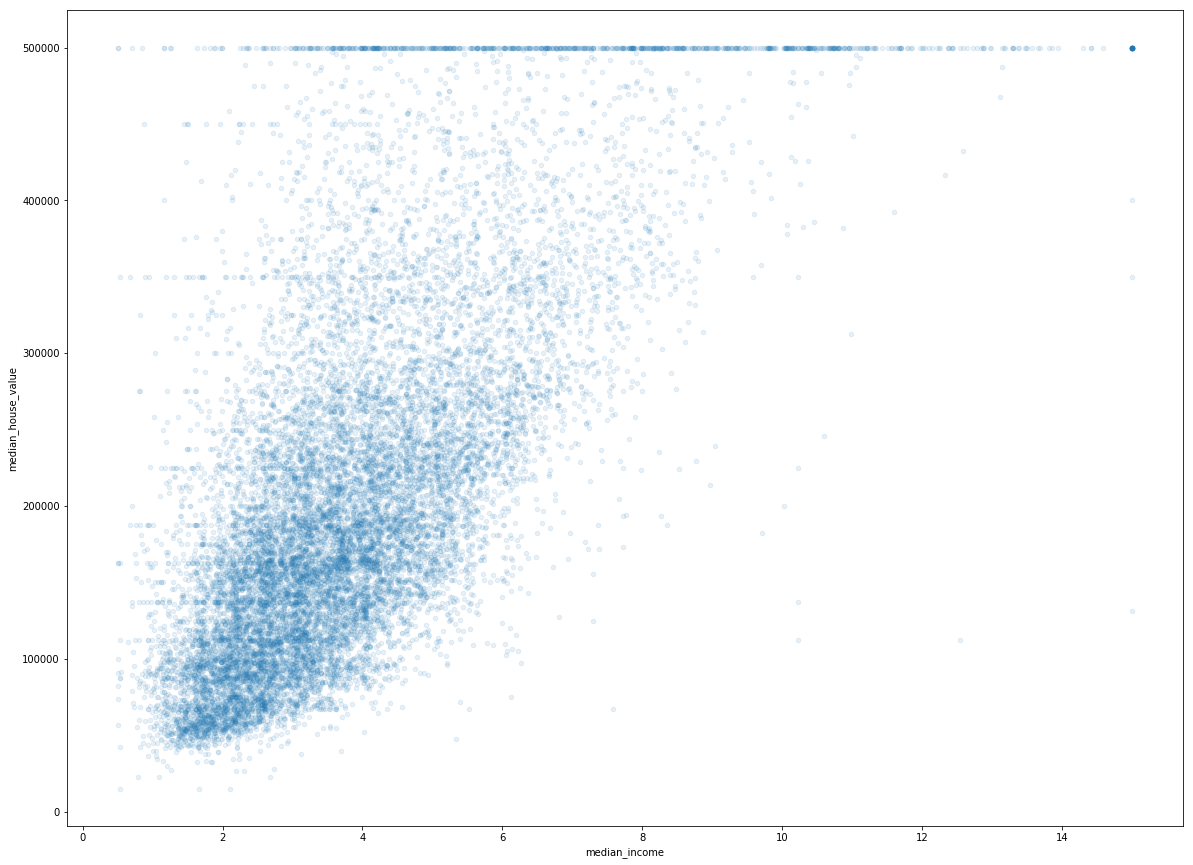

In [30]:
housing_cp.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(20, 15))

In [31]:
housing_cp['rooms_per_households'] = housing_cp['total_rooms'] / housing_cp['households']
housing_cp['bedrooms_per_room'] = housing_cp['total_bedrooms'] / housing_cp['total_rooms']
housing_cp['population_per_household'] = housing_cp['population'] / housing_cp['households']

In [32]:
corr_matrix = housing_cp.corr()

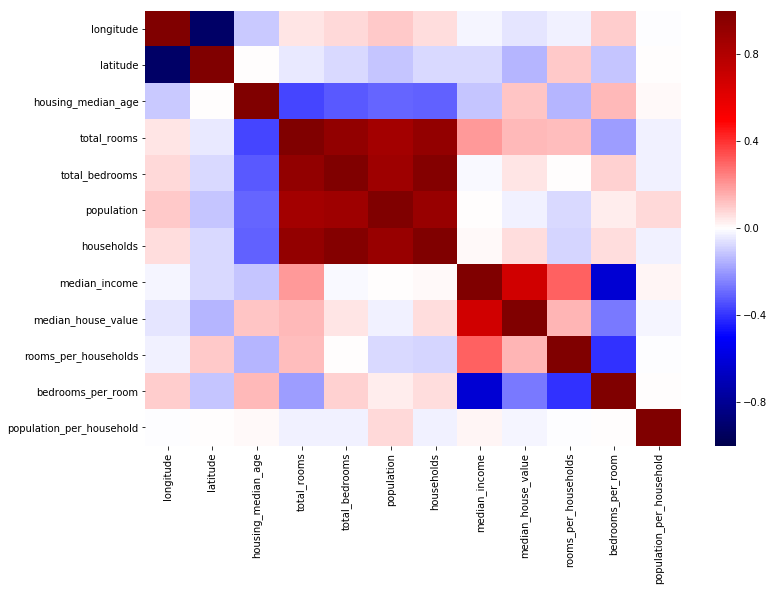

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='seismic')

In [34]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [35]:
housing.dropna(subset=['total_bedrooms']) # Dropa instâncias que tinha total_bedrooms null

housing.drop('total_bedrooms', axis=1) # Dropa a feature inteira

median = housing['total_bedrooms'].median() # Insere a médiana onde valores são nulos
housing['total_bedrooms'].fillna(median); # Miss inplace=True

In [36]:
imputer = Imputer(strategy='median', verbose=1)

In [37]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [38]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=1)

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
housing.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [41]:
X = imputer.transform(housing_num)

In [42]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [43]:
housing_cat = housing['ocean_proximity']

In [44]:
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [45]:
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [46]:
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [47]:
housing_cat_encoded.reshape(-1, 1)

array([[0],
       [0],
       [1],
       ...,
       [2],
       [0],
       [3]])

In [48]:
encoder = OneHotEncoder(sparse=False)

In [49]:
housing_cat_1hot = encoder.fit_transform(housing_cat.values.reshape(-1, 1))

In [50]:
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [51]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [52]:
attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=True)
attr_adder.transform(housing.values)

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 2.7079646017699117,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 2.0259740259740258,
        0.24129098360655737],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 2.742483660130719,
        0.1796086508753862],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 3.808988764044944,
        0.19387755102040816],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.9859154929577465,
        0.22035541195476574]], dtype=object)